# WALLABY user download notebook

A notebook pre-filled with cells and scripts for downloading WALLABY internal release data.

The notebook has the following sections

1. Initialise Django
2. Setup
3. Get release table
4. Export table and data products
5. Appendix

# 1. Initialise Django

The following cells must be run first. They are used to import `django`, set up a connection to the database and import the Django models. Once these cells are run, you are able to use the Django model objects for access to the database.

In [ ]:
# Essential Python libraries for using the ORM

import sys
import os
import django

In [ ]:
# We will provide a plotting script that actually doesn't make use of the products retrieved above. Instead, just provide the detection and they will be retrieved in the function below.

import io
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from django.db import models
from django.forms.models import model_to_dict

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache

from astropy.table import Table

In [ ]:
# Database access environment variables

os.environ["DJANGO_SECRET_KEY"] = "-=(gyah-@e$-ymbz02mhwu6461zv&1&8uojya413ylk!#bwa-l"
os.environ["DJANGO_SETTINGS_MODULE"] = "api.settings"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "True"
os.environ["DATABASE_HOST"] = "146.118.67.204"
os.environ["DATABASE_NAME"] = "wallabydb"
os.environ["DATABASE_USER"] = "wallaby_user"
os.environ["DATABASE_PASSWORD"] = "LKaRsQrNtXZ7vN8L*6"

In [ ]:
# Connect with SoFiAX_services Django ORM

sys.path.append('/mnt/shared/wallaby/apps/SoFiAX_services/api/')
django.setup()

In [ ]:
# Import models

from tables.models import Run, Instance, Detection, Product, Source, SourceDetection, Tag, TagSourceDetection

# 2. Setup

The intention for this notebook is to allow users to easily download all of the products and properties for all sources of a given run. To do this, you run the notebook to completion ("Run" > "Run All Cells" in the menu). If you are using it in this capacity, you can set the Run and whether to download summary plots for all sources in the cells below.

Great! Now we have access to all of the sources for a run.

In [ ]:
# Get all runs and tags

print(Run.objects.all())
print([t.name for t in Tag.objects.all()])

In [ ]:
# Select the tag

run_name = "NGC5044_4"
tag_name = "NGC 5044 DR1"
save_plots = False

# 3. Get release table

The functions above can be useful for interacting with single detections. Suppose you want to work with all sources and their properties for a given Run, or some subset of the sources. The dictionary above needs more manipulation before it can be useful. 

We provide a function below to get the sources and their detection properties, for a subset of the sources and for a given run, into an astropy table. This table format will be more familiar for many astronomers. From this format you are also able to download the file, first to the local file system, then from the menu on the left onto your local computer.

In [ ]:
detection_field_names = [field.name for field in Detection._meta.fields if not isinstance(field, models.ForeignKey)]
source_field_names = [field.name for field in Source._meta.fields if not isinstance(field, models.ForeignKey)]

In [ ]:
print(detection_field_names)
print(source_field_names)

In [ ]:
# get sources and properties from tag

def astropy_table_from_tag(tag_name):
    t = Table()
    
    # get field names
    detection_field_names = [field.name for field in Detection._meta.fields if not isinstance(field, models.ForeignKey)]
    detection_field_names.remove('name')    
    source_field_names = [field.name for field in Source._meta.fields if not isinstance(field, models.ForeignKey)]
    
    # get sources and detections
    source_detections = [SourceDetection.objects.get(id=tsd.source_detection_id) for tsd in TagSourceDetection.objects.filter(tag_id=Tag.objects.get(name=tag_name).id)]
    sources = [Source.objects.get(id=sd.source_id) for sd in source_detections]
    detections = [Detection.objects.get(id=sd.detection_id) for sd in source_detections]
    
    # add columns to the tablef
    for field in source_field_names:
        if field == 'id':
            t['source_id'] = [getattr(s, field) for s in sources]
        else:
            t[field] = [getattr(s, field) for s in sources]
    for field in detection_field_names:
        if field == 'id':
            t['detection_id'] = [getattr(d, field) for d in detections]
        else:
            t[field] = np.array([getattr(d, field) for d in detections], dtype=float)

    return t

In [ ]:
astropy_table_from_tag(tag_name)

Cool! Now to save it as a fits file. 

In [ ]:
# Write table to fits file

table = astropy_table_from_tag(tag_name)
table.write("%s_catalog.fits" % tag_name.replace(' ', '_'), format = 'fits') 

# 4. Export table and associated data products

We can also download the data products (moment maps, spectra) associated with the sources of interest. These are stored in the `Product` table, which we haven't interacted with just yet. All of these data are stored as bytes in the database table, so downloading them allows us to interact with them as `.fits` files (which might be easier for some astronomers). There are also methods for visualising the content directly in these notebooks, which can be found in the `user.ipynb` notebook template.

This script will write a bunch of files for each of the different data products. It's inconvenient to download each of these individually, so we will also zip the content up.

### Save to file

Here we will show you how to save the output products for a given source to a folder. Each of the .fits products will be compressed.

In [ ]:
def write_bytesio_to_file(filename, bytesio):
    """Write the contents of the given BytesIO to a file.
    Creates the file or overwrites the file if it does
    not exist yet. 
    
    """
    with open(filename, "wb") as outfile:
        # Copy the BytesIO stream to the output file
        outfile.write(bytesio.getbuffer())
            
def write_zipped_fits_file(filename, product):
    """Compress a .fits file as .fits.gz for a data product.
   
    """
    with io.BytesIO() as buf:
        buf.write(product)
        buf.seek(0)
        if not os.path.isfile(filename):
            write_bytesio_to_file(filename, buf)
            os.system(f'gzip {filename}')
    
def save_data_products_source(name, detection_id, output_dir):
    """Get the products associated with a source for a given run
    
    """
    detection = Detection.objects.get(id=detection_id)
    products = Product.objects.get(detection=detection)
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    # Write fits files
    write_zipped_fits_file('%s/%s_cube.fits' % (output_dir, name), products.cube)
    write_zipped_fits_file('%s/%s_chan.fits' % (output_dir, name), products.chan)
    write_zipped_fits_file('%s/%s_mask.fits' % (output_dir, name), products.mask)
    write_zipped_fits_file('%s/%s_mom0.fits' % (output_dir, name), products.mom0)
    write_zipped_fits_file('%s/%s_mom1.fits' % (output_dir, name), products.mom1)
    write_zipped_fits_file('%s/%s_mom2.fits' % (output_dir, name), products.mom2)

    # Open spectrum
    with io.BytesIO() as buf:
        buf.write(b''.join(products.spec))
        buf.seek(0)
        spec_file  = '%s/%s_spec.txt' % (output_dir, name)
        if not os.path.isfile(spec_file):
            write_bytesio_to_file(spec_file, buf)

def save_data_products_by_tag(tag_name, output_dir):
    """Save all data products associated with a tagged release
    
    """
    table = astropy_table_from_tag(tag_name)
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    for row in table:
        source_name = row['name'].replace(' ', '_')
        save_data_products_source(source_name, row['detection_id'], f"{output_dir}/{source_name}")
        
    os.system(f'tar -czf {output_dir}.tar.gz {output_dir}')

In [ ]:
# Save data products for a given source to a folder

source = Source.objects.get(id=table[0]['source_id'])
detection = Detection.objects.get(id=table[0]['detection_id'])
source_name = source.name.replace(' ', '_')

if not os.path.isdir('%s' % source_name):
    os.mkdir('%s' % source_name)

save_data_products_source(name=source_name, detection_id=detection.id, output_dir='%s' % source_name)

In [ ]:
# Save data products for an entire tagged collection

save_data_products_by_tag(tag_name, '%s_products' % tag_name.replace(' ', '_'))

## Summary plots

We can generate summary plots of moment 0, moment 1 maps, spectra and optical counterpart for a source to quickly visualise it. We will also provide some code for saving these plots in a zipped folder like for products in the cells above. Storing all summary plots for an entire release takes a **very** long time (~1 hour for 350 sources) so it may be easier to visualise them in the notebook. We will show an example of that as well.

In [ ]:
# Create a summary plot of source products

def summary_plot(detection, source, save=False, output_dir=None):
    # Plot figure size    
    interval = PercentileInterval(95.0)
    interval2 = PercentileInterval(90.0)
    plt.rcParams["figure.figsize"] = (12,12)
    
    # Retrieve products from database
    products = Product.objects.get(detection=detection)

    # Open moment 0 image
    with io.BytesIO() as buf:
        buf.write(products.mom0)
        buf.seek(0)
        hdu_mom0 = fits.open(buf)[0]
        wcs = WCS(hdu_mom0.header)
        mom0 = hdu_mom0.data

    # Open moment 1 image
    with io.BytesIO() as buf:
        buf.write(products.mom1)
        buf.seek(0)
        hdu_mom1 = fits.open(buf)[0]
        mom1 = hdu_mom1.data

    # Spectrum
    with io.BytesIO() as buf:
        buf.write(b''.join(products.spec))
        buf.seek(0)
        spectrum = np.loadtxt(buf, dtype="float", comments="#", unpack=True)

    # Extract coordinate information
    nx = hdu_mom0.header["NAXIS1"]
    ny = hdu_mom0.header["NAXIS2"]
    clon, clat = wcs.all_pix2world(nx/2, ny/2, 0)
    tmp1, tmp3 = wcs.all_pix2world(0, ny/2, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx, ny/2, 0)
    width = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    tmp1, tmp3 = wcs.all_pix2world(nx/2, 0, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx/2, ny, 0)
    height = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))

    # Download DSS image from SkyView
    hdu_opt = SkyView.get_images(
        position="{}, {}".format(clon, clat),
        survey="DSS",
        coordinates="J2000",
        projection="Tan",
        width=width*u.deg,
        height=height*u.deg,
        cache=None
    )[0][0]
    wcs_opt = WCS(hdu_opt.header)

    # Plot moment 0
    ax2 = plt.subplot(2, 2, 1, projection=wcs);
    ax2.imshow(mom0, origin="lower");
    ax2.grid(color="grey", ls="solid");
    ax2.set_xlabel("Right ascension (J2000)");
    ax2.set_ylabel("Declination (J2000)");
    ax2.tick_params(axis="x", which="both", left=False, right=False);
    ax2.tick_params(axis="y", which="both", top=False, bottom=False);
    ax2.set_title("moment 0");

    # Add beam size     
    e = Ellipse((5, 5), 5, 5, 0, edgecolor='peru', facecolor='peru');
    ax2.add_patch(e);

    # Plot DSS image with HI contours
    bmin, bmax = interval2.get_limits(hdu_opt.data);
    ax = plt.subplot(2, 2, 2, projection=wcs_opt);
    ax.imshow(hdu_opt.data, origin="lower");
    ax.contour(hdu_mom0.data, transform=ax.get_transform(wcs), levels=np.logspace(2.0, 5.0, 10), colors="lightgrey", alpha=1.0);
    ax.grid(color="grey", ls="solid");
    ax.set_xlabel("Right ascension (J2000)");
    ax.set_ylabel("Declination (J2000)");
    ax.tick_params(axis="x", which="both", left=False, right=False);
    ax.tick_params(axis="y", which="both", top=False, bottom=False);
    ax.set_title("DSS + moment 0");

    # Plot moment 1
    bmin, bmax = interval.get_limits(mom1);
    ax3 = plt.subplot(2, 2, 3, projection=wcs);
    ax3.imshow(hdu_mom1.data, origin="lower", vmin=bmin, vmax=bmax, cmap=plt.get_cmap("gist_rainbow"));
    ax3.grid(color="grey", ls="solid");
    ax3.set_xlabel("Right ascension (J2000)");
    ax3.set_ylabel("Declination (J2000)");
    ax3.tick_params(axis="x", which="both", left=False, right=False);
    ax3.tick_params(axis="y", which="both", top=False, bottom=False);
    ax3.set_title("moment 1");

    # Plot spectrum
    xaxis = spectrum[1] / 1e+6;
    data  = 1000.0 * np.nan_to_num(spectrum[2]);
    xmin = np.nanmin(xaxis);
    xmax = np.nanmax(xaxis);
    ymin = np.nanmin(data);
    ymax = np.nanmax(data);
    ymin -= 0.1 * (ymax - ymin);
    ymax += 0.1 * (ymax - ymin);
    ax4 = plt.subplot(2, 2, 4);
    ax4.step(xaxis, data, where="mid", color="royalblue");
    ax4.set_xlabel("Frequency (MHz)");
    ax4.set_ylabel("Flux density (mJy)");
    ax4.set_title("spectrum");
    ax4.grid(True);
    ax4.set_xlim([xmin, xmax]);
    ax4.set_ylim([ymin, ymax]);

    plt.suptitle(source.name, fontsize=16);
    
    if save and output_dir is not None:
        plt.savefig("%s/%s_summary.png" % (output_dir, source.name.replace(' ', '_')))
        plt.close()
    else:
        plt.show()
        
def save_summary_plots_by_tag(tag_name, output_dir):
    """Save summary plots for all sources given by a specified tag
    
    """
    table = astropy_table_from_tag(tag_name)
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    for row in table:
        source = Source.objects.get(id=row['source_id'])
        detection = Detection.objects.get(id=row['detection_id'])
        summary_plot(detection, source, save=True, output_dir=output_dir)
        
    os.system(f'tar -czf {output_dir}.tar.gz {output_dir}')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

save_summary_plots_by_tag(tag_name, '%s_summary_plots' % tag_name.replace(' ', '_'))

# That's it!

If you have any thoughts or anything you think we should add to this notebook please contact [austin.shen@csiro.au](mailto:austin.shen@csiro.au)

---

# 5. Appendix

If you want to know more about what is happening underneath the hood. Most of this will not be necessary for using WALLABY data.

## Query runs, detections and sources

Now that we have imported the Django models, we are able to use them for viewing tables in the database. We'll provide a few examples for how to get objects from the database, but for a more comprehensive guide you can look at the documentation [here](https://docs.djangoproject.com/en/3.2/topics/db/queries/#retrieving-objects).

To get a list of the sources we will need to decide which run we are interested in. This run is the region of sky. We can query the database to look the runs that are in the database. With Django, the rows of the database are retrieved in the form of Django objects called [QuerySets](https://docs.djangoproject.com/en/3.2/ref/models/querysets/). We can essentially treat them as lists (and can be converted directly to a native Python list with `list()` on the object).

### Table structure

Since we are interested in retrieving sources, we need to know how to get them for a given run. The diagram below shows the relationship between the run and sources tables. You can see that there is an intermediate source_detection table that is used to map a source and a detection, and that there is a relationship between the detection and run. 

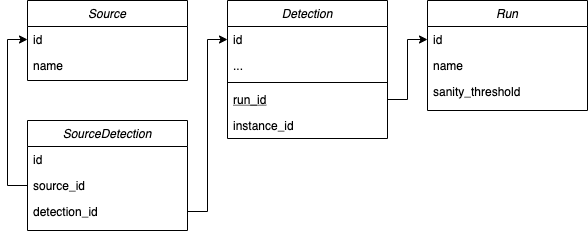

So, started from the run we must do the following to get access to the sources using foreign key relationships:

1. Get Detections of interest in a Run
2. Get SourceDetection map from Detections
3. Get Sources from SourceDetection source_id field

In [ ]:
# 0. List all runs in the database

Run.objects.all()

In [ ]:
# 1. Get detections of interest in a run

detections = Detection.objects.filter(run_id = Run.objects.get(name=run_name))

In [ ]:
# 2. Get the source_detection map for detections to get the source ids

detections_to_sources = SourceDetection.objects.filter(detection_id__in=[d.id for d in detections])

In [ ]:
# 3. Get the sources from the source_detection ids

sources = Source.objects.filter(id__in=[d.source_id for d in detections_to_sources])
print([s.name for s in sources])

## View source properties

It's probably not useful to just be able to see the names of the sources. We want to look at the source properties obtained from the source finding application, or at the data products associated with it. To start to access these we first need to know the structure of the tables of interest. Let's look at the schema for the two tables in the cells below.

In [ ]:
# Source table fields

Source._meta.fields

In [ ]:
# Detection table fields

Detection._meta.fields

So we now know that all of the properties that are useful for science are in the detections table. Great, we'll need to map the source to detection to get these. The function below will help you to do this.

The functions below will take an object/instance of the source (not just the source name) and retrieve its properties. Without going into it too much, we'll also need to provide the name of the run since there can be multiple detections for a given source. We'll also show you how to get the object from the source name as well.

In [ ]:
# Functions for getting the properties of a source

def get_detection(source_name, run_name):
    """Get the detection for a given source and run.
    
    """
    source = Source.objects.get(name=source_name)
    detection_ids = [sd.detection_id for sd in SourceDetection.objects.filter(source_id=source.id)]
    
    # where there is only 1 detection     
    if (len(detection_ids) == 1):
        detection = Detection.objects.get(id=detection_ids[0])
        return detection

    # Need to specify the run    
    detection = Detection.objects.filter(id__in=detection_ids).filter(run_id=run.id).first()
    return detection
    

def get_property(source_name, run_name, attribute):
    """Retrieve a single property (name) for a source in a given run.
    
    """
    detection = get_detection(source_name, run_name)
    return getattr(detection, attribute)


def get_all_properties(source_name, run_name):
    """Retrieve the value of all properties for a source in a given run.
    
    """
    detection = get_detection(source_name, run_name)
    return model_to_dict(detection)


print(f"f_max for WALLABY_J122708+055255: {get_property(source_name='WALLABY_J122708+055255', run_name=run_name, attribute='f_max')}")
print(f"All property values for WALLABY_J122708+055255: {get_all_properties(source_name='WALLABY_J122708+055255', run_name=run_name)}")